# 1. HEART DISEASE CLEVELAND DESCRIPTION

## 1.1 PROBLEM END GOAL
* The goal of the problem is to predict the target variable, called ***condition***.
* It has only two unique associated values, so let's treat this a binary classification problem.

## 1.2 FEATURE DESCRIPTION
**FEATURES:**  
1. age | Number of years a person has lived
2. sex | Gender of patient (Male:1/Female:0)
3. cp | Chest Pain type (4 values)
4. trestbps | Resting Blood Pressure
5. chol | serum cholestoral in mg/dl
6. fbs | Fasting Blood Sugar > 120 mg/dl
7. restecg | Resting Electrocardiographic (ECG) results (values 0,1,2)
8. thalach | Maximum Heart Rate Achieved
9. exang | Exercise Induced Angina
10. oldpeak | oldpeak = ST depression induced by exercise relative to rest
11. slope | the slope of the peak exercise ST segment
12. ca | number of major vessels (0-3) colored by flourosopy
13. thal | Thalium stress test results: 3 = normal; 6 = fixed defect; 7 = reversable defect

**TARGET VARIABLE:**  
Target Variable, from original dataset
condition: diagnosis of heart disease (angiographic disease status)
Value 0: < 50% diameter narrowing (negative for disease)
Value 1: > 50% diameter narrowing (positive for disease)

**Feature Types:**  
All features are numerical features, however some of them are converted categorical features, we'll know which is which when looking into EDA.

In [33]:
import sys
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# Also check functions:
sys.path.append(os.path.join(os.path.abspath("../ml_project")))

import ml_project.enities
from ml_project.data import (
    download_data_from_gdrive,
    read_data,
    split_train_val_data,
)
from ml_project.features import make_features
from ml_project.features.build_features import (
    extract_target,
    build_transformer,
)
from ml_project.models import (
    train_model,
    serialize_model,
    predict_model,
    evaluate_model,
    create_pipeline
)


In [4]:
%load_ext autoreload
%autoreload 2

**Training params**

In [29]:
ml_project.enities.register_train_configs()
with initialize(config_path="../configs"):
    params = compose(config_name="train_config")
    print(OmegaConf.to_yaml(params))

output_model_path: models/model.pkl
metric_path: models/metrics.json
downloading_params:
  gdrive_id: 1Q0JMqL54o6VCJ0tkMvb6jIzyPFJjy0FQ
  output_folder: ../../data/raw/
splitting_params:
  val_size: 0.2
  random_state: ${general.random_state}
feature_params:
  categorical_features:
  - sex
  - cp
  - fbs
  - restecg
  - exang
  - slope
  - ca
  - thal
  numerical_features:
  - age
  - trestbps
  - chol
  - thalach
  - oldpeak
  target_col: condition
transform_params:
  ohe_categorical: true
  normilize_numerical: true
mlflow_params:
  mlflow_uri: mlruns
  mlflow_experiment: ml_project
model:
  max_depth: 3
  _target_: sklearn.ensemble.RandomForestClassifier
  n_estimators: 100
  random_state: ${general.random_state}
general:
  random_state: 42



# 2. EXPLORATORY DATA ANALYSIS

In [6]:
path = download_data_from_gdrive(params.downloading_params)
data = read_data(path)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,2.158249,0.964859,0.0,2.0,2.0,3.0,3.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


In [9]:
data["condition"].value_counts()

0    160
1    137
Name: condition, dtype: int64

In [10]:
categorical = [i for i in data.loc[:,data.nunique()<=10]]
continuous = [i for i in data.loc[:,data.nunique()>=10]]
print(f"categorical features: {categorical}")
print(f"continuous features: {continuous}")

categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'condition']
continuous features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


<Figure size 1440x864 with 0 Axes>

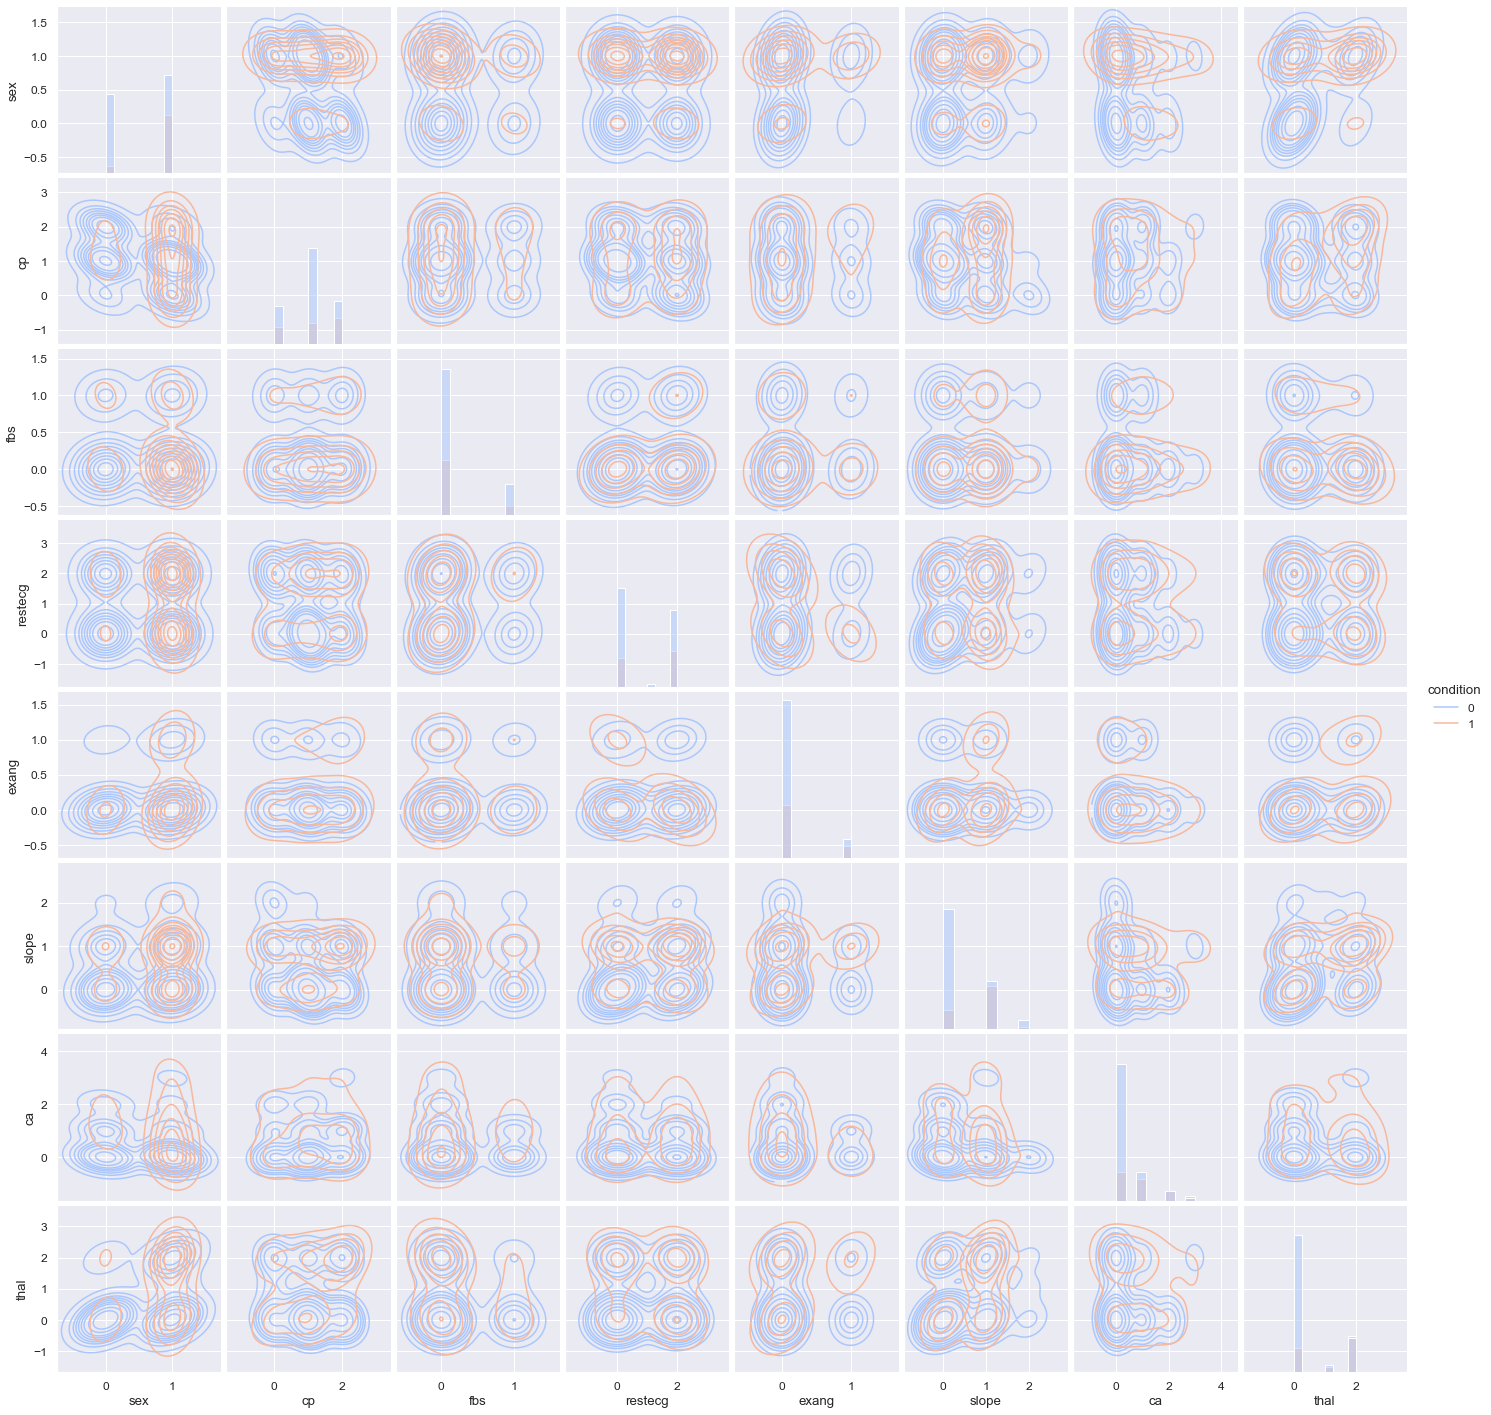

In [11]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20, 12))
sns.pairplot(data.loc[:100, categorical], hue="condition", kind="kde", diag_kind="hist", palette="coolwarm")
plt.show()

<Figure size 1440x864 with 0 Axes>

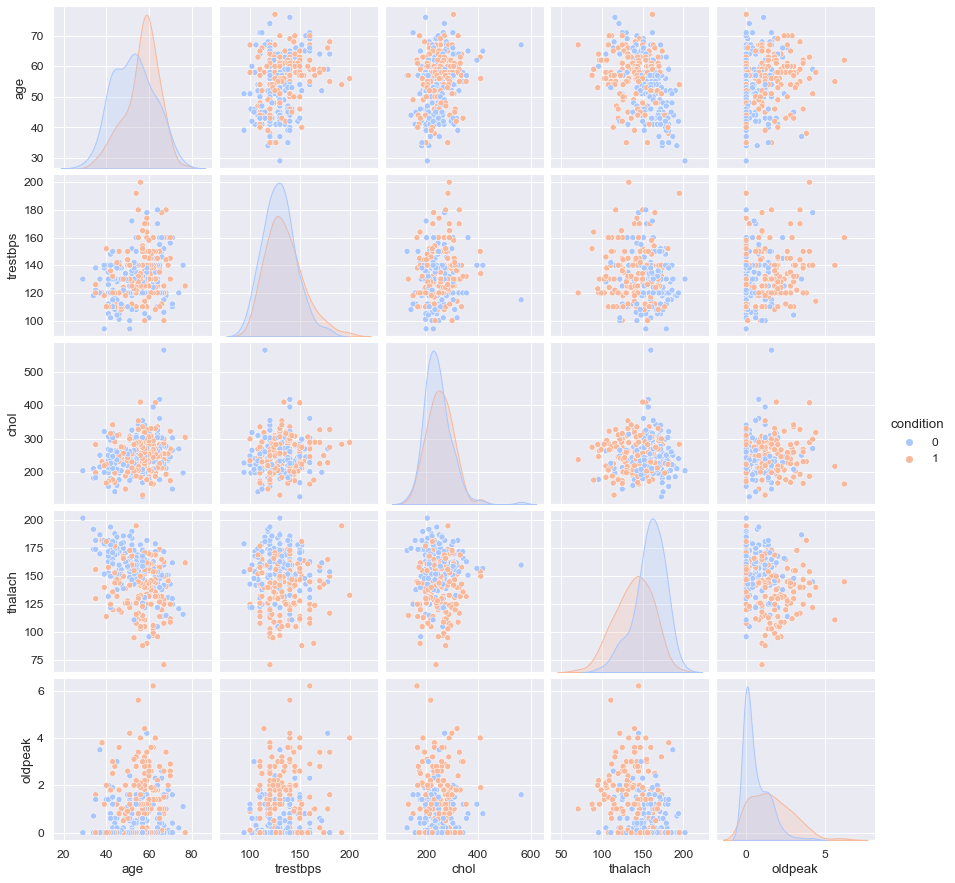

In [12]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20, 12))
sns.pairplot(data[continuous + ["condition"]], hue="condition", palette="coolwarm")
plt.show()

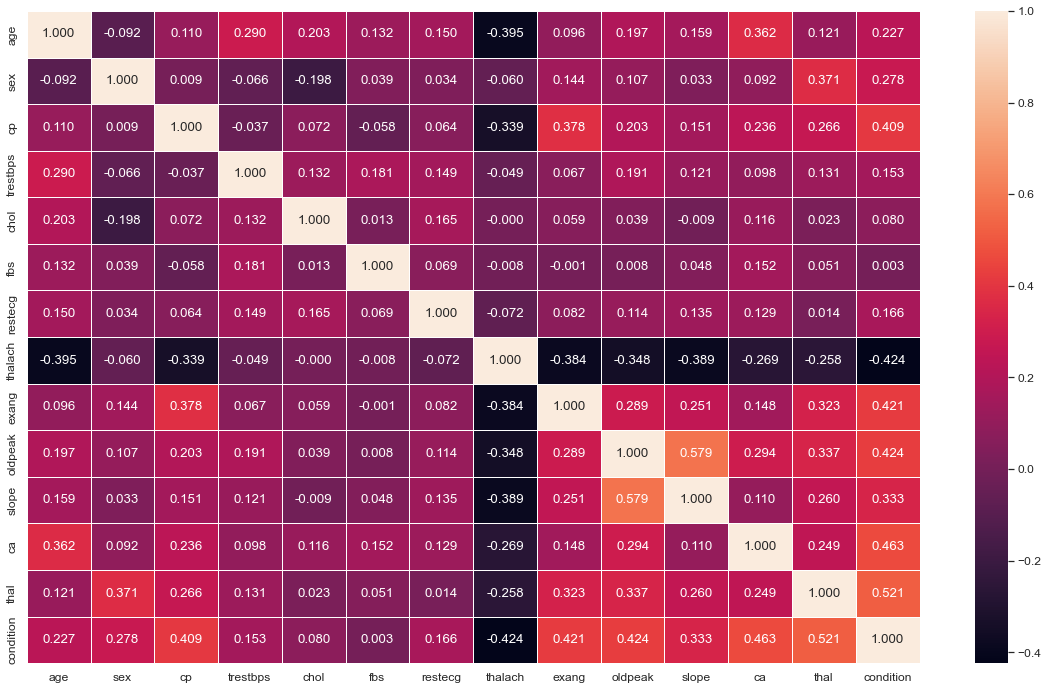

In [13]:
correlation_train = data.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            # cmap='Wistia',
            linewidths=1,
            cbar=True)
plt.show()

# 3. TRAIN BASE MODEL

In [19]:
model = instantiate(params.model)

train_df, val_df = split_train_val_data(data, params.splitting_params)

train_target = extract_target(train_df, params.feature_params)
val_target = extract_target(val_df, params.feature_params)
train_df = train_df.drop(labels=params.feature_params.target_col, axis=1)
val_df = val_df.drop(labels=params.feature_params.target_col, axis=1)

transformer = build_transformer(params.feature_params, params.transform_params)

transformer.fit(train_df)

train_features = make_features(transformer, train_df)

model = train_model(train_features, train_target, model)
inference_pipeline = create_pipeline(model, transformer)
predicts = predict_model(
    inference_pipeline,
    val_df
)
metrics = evaluate_model(
    predicts,
    val_target,
)
print(f"model : {model}\nmetrics: {metrics}")

model : RandomForestClassifier(max_depth=3, random_state=42)
metrics: {'accuracy': 0.75, 'precision': 0.7407407407407407, 'roc auc score': 0.7477678571428572}


Проверим сохранение обученной модели:

In [20]:
os.makedirs(os.path.dirname(params.metric_path), exist_ok=True)
with open(params.metric_path, "w") as metric_file:
    json.dump(metrics, metric_file)


path_to_model = serialize_model(inference_pipeline, params.output_model_path)

In [39]:
synthetic_data_raw = {}
for column in data.columns:
    uniq = data[column].unique()
    synthetic_data_raw[column] = list(uniq) if len(uniq) < 5 else [min(uniq), max(uniq)]
    # print(f"{column}\n{uniq if len(uniq) < 5 else [min(uniq), max(uniq)]}")
synthetic_data_raw

{'age': [29, 77],
 'sex': [1, 0],
 'cp': [0, 1, 2, 3],
 'trestbps': [94, 200],
 'chol': [126, 564],
 'fbs': [1, 0],
 'restecg': [2, 0, 1],
 'thalach': [71, 202],
 'exang': [0, 1],
 'oldpeak': [0.0, 6.2],
 'slope': [1, 0, 2],
 'ca': [1, 2, 0, 3],
 'thal': [0, 2, 1],
 'condition': [0, 1]}

In [42]:
synthetic_data = {}
TRAIN_DATA_SIZE = 100
for column, values in synthetic_data_raw.items():
    synthetic_data[column] = np.random.choice(values, TRAIN_DATA_SIZE)
s_d = pd.DataFrame(synthetic_data)

In [43]:
s_d

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,77,1,3,200,126,0,2,71,1,0.0,2,1,2,0
1,77,1,0,94,126,1,1,202,0,0.0,1,3,2,1
2,29,0,3,94,564,0,1,71,1,6.2,0,3,2,1
3,77,0,0,200,126,0,1,202,1,6.2,0,1,0,0
4,29,1,1,94,126,0,1,202,1,0.0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,29,0,2,200,564,0,1,71,0,0.0,2,3,0,0
96,29,0,0,200,126,0,0,71,0,6.2,1,2,2,0
97,29,1,0,94,564,1,2,202,1,6.2,2,0,0,1
98,29,0,3,94,126,0,2,71,0,0.0,2,0,0,0


In [25]:
data.iloc[:50, :-1].to_csv("features.csv", index=False)